In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.stats.multicomp
import statsmodels.api as sm
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal, levene, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns


Считываем данные

In [11]:
auth_data = pd.read_csv('problem1-auth_data.csv', sep= ";")
reg_data = pd.read_csv('problem1-reg_data.csv', sep= ";")


Разведочный анализ данных

In [12]:
reg_data.describe(), reg_data.info() # Основная информация и статистика по данным

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


(             reg_ts           uid
 count  1.000000e+06  1.000000e+06
 mean   1.548332e+09  5.552354e+05
 std    5.253653e+07  3.206011e+05
 min    9.113822e+08  1.000000e+00
 25%    1.528034e+09  2.776438e+05
 50%    1.564454e+09  5.550455e+05
 75%    1.585759e+09  8.329712e+05
 max    1.600874e+09  1.110622e+06,
 None)

In [13]:
auth_data.describe(), auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


(            auth_ts           uid
 count  9.601013e+06  9.601013e+06
 mean   1.548778e+09  3.347198e+05
 std    5.160527e+07  2.832669e+05
 min    9.113822e+08  1.000000e+00
 25%    1.528375e+09  9.599700e+04
 50%    1.564577e+09  2.579210e+05
 75%    1.585823e+09  5.190250e+05
 max    1.600874e+09  1.110622e+06,
 None)

In [14]:
reg_data.isnull().sum(), auth_data.isnull().sum() # Проверка на пропуски в данных

(reg_ts    0
 uid       0
 dtype: int64,
 auth_ts    0
 uid        0
 dtype: int64)

In [15]:
reg_data['uid'].nunique(), len (reg_data['uid']) # Проверка на уникальность пользователей с датами регистрации

(1000000, 1000000)

<Axes: >

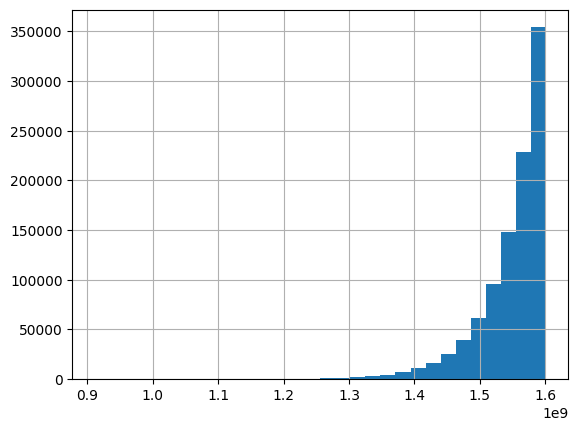

In [16]:
reg_data['reg_ts'].hist(bins=30) # Проверка распределений данных

<Axes: >

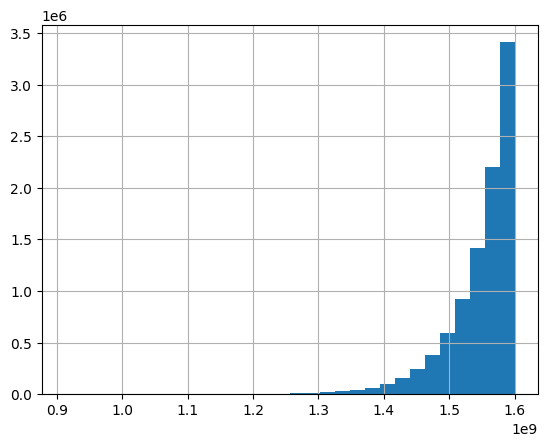

In [17]:
auth_data['auth_ts'].hist(bins=30) # Проверка распределений данных

<Axes: >

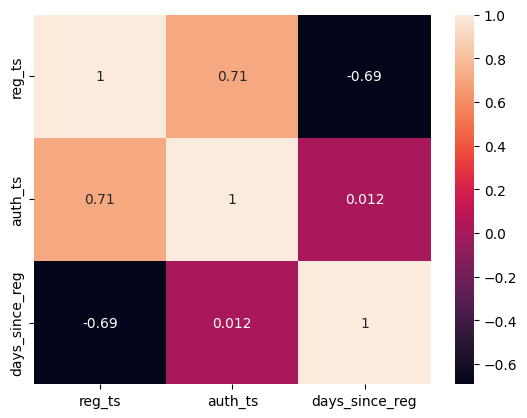

In [23]:
# Корреляции между различными переменными временем регистрации и временем первого входа. Перед выполнением этого блока нужно запустить блок, в котором вводится merged_data  
corr_matrix = merged_data[['reg_ts', 'auth_ts', 'days_since_reg']].corr()
sns.heatmap(corr_matrix, annot=True)

Отрицательная корреляция (-0.69) между временем регистрации и количеством дней до первого входа указывает на то, что чем раньше регистрация, тем больше времени может пройти до первого входа.

In [19]:
reg_data.duplicated().sum(), auth_data.duplicated().sum() # Проверка дубликатов

(0, 0)

Данные по регистрации и авторизации пользователей содержат 1,000,000 уникальных пользователей и 9,601,013 записей о входах в игру, соответственно. Пропуски и дубликаты в данных отсутствуют, что говорит о высокой чистоте данных. Количество регистраций значительно возросло после 2010 года, с пиком в 2020 году. Аналогично, количество авторизаций также увеличивалось, что свидетельствует о росте популярности игры в последние годы.

Рост регистраций и активностей в последние годы может быть связан с маркетинговыми кампаниями или новыми функциями игры.

1 ЗАДАНИЕ

Превратим столбцы с секундами в даты

In [24]:
reg_data['reg_ts']= pd.to_datetime(reg_data['reg_ts'], unit='s')
auth_data['auth_ts']= pd.to_datetime(auth_data['auth_ts'], unit='s')
reg_data

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5
...,...,...
999995,2020-09-23 15:13:54,1110618
999996,2020-09-23 15:14:46,1110619
999997,2020-09-23 15:15:39,1110620
999998,2020-09-23 15:16:31,1110621


In [25]:
merged_data = pd.merge(auth_data, reg_data, on='uid', how='inner')
merged_data['days_since_reg'] = (merged_data['auth_ts'] - merged_data['reg_ts']).dt.days # Вычисляем количество дней между регистрацией и авторизацией
auth_data

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2
...,...,...
9601008,2020-09-23 15:13:54,1110618
9601009,2020-09-23 15:14:46,1110619
9601010,2020-09-23 15:15:39,1110620
9601011,2020-09-23 15:16:31,1110621


In [26]:
merged_data

,auth_ts,uid,reg_ts,days_since_reg
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,0
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,0
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09,2
3,1999-07-31 03:50:15,2,1999-07-22 22:38:09,8
4,1999-08-05 17:49:39,2,1999-07-22 22:38:09,13
...,...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54,0
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46,0
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39,0
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31,0


days_since_reg   0          1     2          3     4     5          6     \
reg_date                                                                   
2010-01-01      100.0   0.000000   0.0   0.000000   0.0   0.0  33.333333   
2010-01-02      100.0   0.000000   0.0   0.000000   0.0   0.0  50.000000   
2010-01-03      100.0   0.000000   0.0  33.333333   0.0   0.0  33.333333   
2010-01-04      100.0  33.333333   0.0  33.333333   0.0   0.0   0.000000   
2010-01-05      100.0   0.000000   0.0  50.000000  50.0   0.0   0.000000   
...               ...        ...   ...        ...   ...   ...        ...   
2010-09-28      100.0   0.000000   0.0   0.000000   0.0   0.0   0.000000   
2010-09-29      100.0  25.000000   0.0   0.000000   0.0  50.0   0.000000   
2010-09-30      100.0   0.000000  20.0   0.000000   0.0   0.0   0.000000   
2010-10-01      100.0  25.000000  25.0  25.000000   0.0   0.0   0.000000   
2010-10-02      100.0   0.000000   0.0  25.000000   0.0   0.0   0.000000   

days_since_

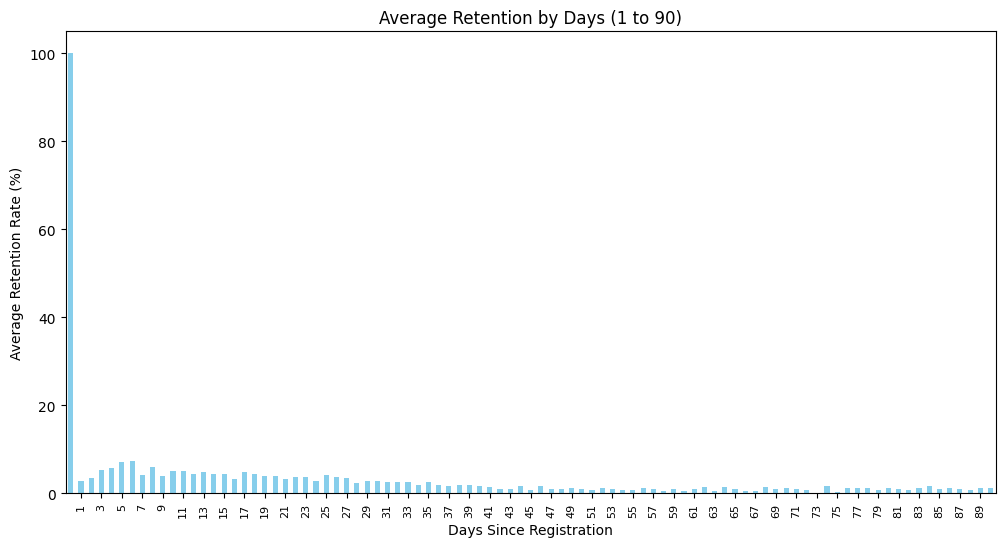

In [27]:


import pandas as pd
import matplotlib.pyplot as plt

def calculate_retention(merged_data, reg_data, days_list, max_days, start_date=None, end_date=None):
    
    # Фильтруем данные по дате регистрации с учётом max_days и создаём копию DataFrame
    if start_date and end_date:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        reg_data = reg_data[(reg_data['reg_ts'] >= start_date) & (reg_data['reg_ts'] <= end_date - pd.Timedelta(days=max_days))].copy()
        merged_data = merged_data[(merged_data['reg_ts'] >= start_date) & (merged_data['reg_ts'] <= end_date - pd.Timedelta(days=max_days))].copy()
    
    # Округляем даты до начала дня
    merged_data['reg_date'] = merged_data['reg_ts'].dt.floor('D')
    merged_data['auth_date'] = merged_data['auth_ts'].dt.floor('D')
    
    # Рассчитываем дни с момента регистрации
    #merged_data['days_since_reg'] = (merged_data['auth_date'] - merged_data['reg_date']).dt.days
    
    # Создаём сводную таблицу для расчёта retention
    retention = merged_data.pivot_table(
        index='reg_date',
        columns='days_since_reg',
        values='uid',
        aggfunc=pd.Series.nunique
    ).fillna(0)
    
    # Размер когорты — количество пользователей, зарегистрировавшихся в каждый день
    cohort_sizes = retention[0]
    
    # Рассчитываем процент удержания
    retention_rate = retention.divide(cohort_sizes, axis=0) * 100
    print (retention_rate)
    # Усредняем retention по всем когортам
    avg_retention = retention_rate.mean(axis=0)[:max_days+1]
    print (avg_retention)
    

    # Выводим retention для указанных дней
    for day in days_list:
        rate = avg_retention.get(day, 0)
        print(f"Day {day}: Retention: {rate:.2f}%")
    
    # Строим график удержания
    plt.figure(figsize=(12, 6))
    avg_retention.plot(kind='bar', color='skyblue')
    plt.xlabel('Days Since Registration')
    plt.ylabel('Average Retention Rate (%)')
    plt.title(f'Average Retention by Days (1 to {max_days})')
    plt.xticks(range(1, max_days + 1, 2), fontsize=8)
    plt.show()



start_date = '2010-01-01'
end_date = '2011-01-01'
days_to_calculate = [1, 7, 30, 60, 90]
max_days = 90

calculate_retention(merged_data, reg_data, days_to_calculate, max_days, start_date, end_date)


График показывает умеренное снижение retention в первые 30 дней: с 3.36% на 1-й день до 3.06% на 30-й день. Увеличение retention на 6-й день до ~% может указывать на какое-то событие или акцию, стимулирующую возврат пользователей. После 40 дней кривая снижается медленнее (скорее даже параллельна оси X), что указывает на большую лояльность оставшихся пользователей. 

Возможности увеличения retention: 
1) Проанализировать, что могло вызвать рост активности на 6-й день, и использовать это для увеличения retention на других этапах. 
2) Сфокусироваться на улучшении удержания в первые 40 дней через персонализированные предложения или акции.
3) Поощрять лояльных пользователей после 40-го дня через программы лояльности или эксклюзивный контент.

2 ЗАДАНИЕ

In [28]:
gen_data = pd.read_csv('Проект_1_Задание_2 (1).csv', sep= ";")
gen_data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Разведочный анализ данных

In [29]:
gen_data.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [30]:
gen_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [31]:
gen_data.isnull().sum() #проверка на наличие пустых строк

user_id      0
revenue      0
testgroup    0
dtype: int64

In [32]:
gen_data.duplicated().sum() # Проверка на дубликаты

0

In [33]:
gen_data.user_id.nunique(), len (gen_data) # Проверяем уникальность информации про каждого пользователя

(404770, 404770)

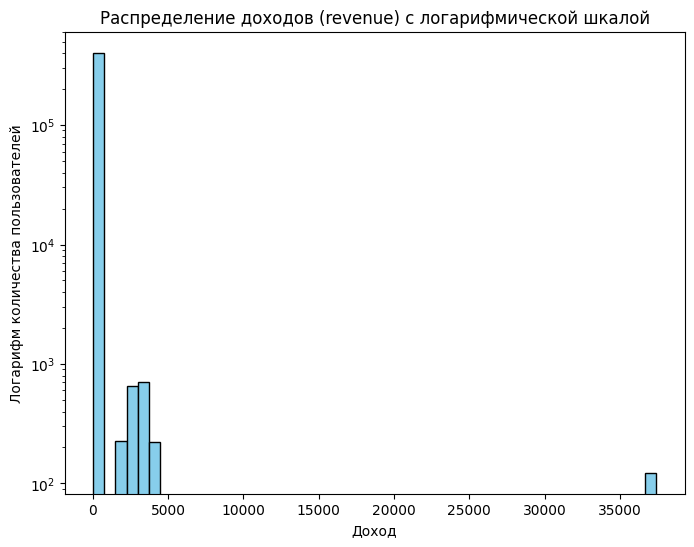

In [34]:
# Анализ распределения доходов (гистограмма доходов). Используется логарифмическая шкала, потому что она лучше отображает малозаметные результаты
plt.figure(figsize=(8, 6))
plt.hist(gen_data['revenue'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.title('Распределение доходов (revenue) с логарифмической шкалой')
plt.xlabel('Доход')
plt.ylabel('Логарифм количества пользователей')
plt.show()

In [35]:
# Считаем количество пользователей с нулевым доходом и с положительным доходом
zero_revenue_count = (gen_data['revenue'] == 0).sum()
positive_revenue_count = (gen_data['revenue'] > 0).sum()
zero_revenue_count, positive_revenue_count

(401037, 3733)

In [36]:
# Распределение пользователей по тестовым группам
group_counts = gen_data['testgroup'].value_counts()
group_counts

testgroup
b    202667
a    202103
Name: count, dtype: int64

In [37]:
# Средний доход на пользователя в каждой группе
mean_revenue_per_group = gen_data.groupby('testgroup')['revenue'].mean()
mean_revenue_per_group

testgroup
a    25.413720
b    26.751287
Name: revenue, dtype: float64

In [38]:
gen_data.groupby('testgroup').size()

testgroup
a    202103
b    202667
dtype: int64

Средний доход на пользователя составляет 26.08 единиц, но медианный доход равен 0, что указывает на то, что большинство пользователей не приносит доход. Максимальный доход достигает 37433 единиц, что свидетельствует о наличии небольшого числа крупных покупателей, которые существенно влияют на общие показатели. Гистограмма доходов подтверждает, что 401037 пользователей (99.1%) имеют нулевой доход, и только 3733 пользователей (0.9%) совершили покупки.

Тестовая группа b включает 202667 пользователей, а контрольная группа a — 202103, что говорит о практически равной численности групп, что важно для корректного проведения A/B-теста.

Низкая конверсия (всего 0.9% пользователей вносят доход) требует внимания, так как это ключевой показатель для анализа. Также необходимо учесть влияние крупных покупателей, которые могут искажать средние значения доходов, и проанализировать их влияние на результаты теста.

ТЕСТЫ

1) Используем тест хи-квадрат для проверки наличия связи между принадлежности к группе и факта покупки. Мы можем его использовать, потому что наблюдения независимы и количество наблюдений очень большое. Нулевая гипотеза (H₀): Две переменные независимы, то есть принадлежность к группе не влияет на покупку. Альтернативная гипотеза (H₁): Между переменными существует зависимость, то есть вероятность покупки зависит от принадлежности к группе.

In [39]:
table = pd.crosstab (gen_data['testgroup'], gen_data['revenue'] > 0)
chi2, p, dof, expected = chi2_contingency(table)
table

revenue,False,True
testgroup,,
a,200175,1928
b,200862,1805


In [40]:
f"χ²: {chi2}, p-value: {p}"

'χ²: 4.374729521260405, p-value: 0.03647561892312613'

Результаты теста показали, что принадлежность к группе (контрольной или тестовой) влияет на вероятность того, что пользователь станет платящим (p < 0.05). При этом контрольная группа имеет больше платящих пользователей, что может указывать на то, что тестовое предложение (в группе b) менее эффективно именнно с точки зрения создания стимулов для того, чтобы пользователь стал платящим.

2) Посмотрим на структуру выборок

In [41]:
# Создадим два датафрейма для каждой группы платящих пользователей
a_paying= gen_data.query('testgroup == "a" & revenue > 0')
b_paying= gen_data.query('testgroup == "b" & revenue > 0')


shapiro_test_a = shapiro(a_paying.revenue)
shapiro_test_b = shapiro(b_paying.revenue)
shapiro_test_a, shapiro_test_b

(ShapiroResult(statistic=0.2667928283980482, pvalue=6.429637191232859e-66),
 ShapiroResult(statistic=0.9583127651738007, pvalue=2.491925378538669e-22))

p-value < 0.05 для обеих групп: Значение p-value в обеих группах очень маленькое (намного меньше порогового значения 0.05), что говорит о том, что распределение данных в обеих группах не является нормальным.

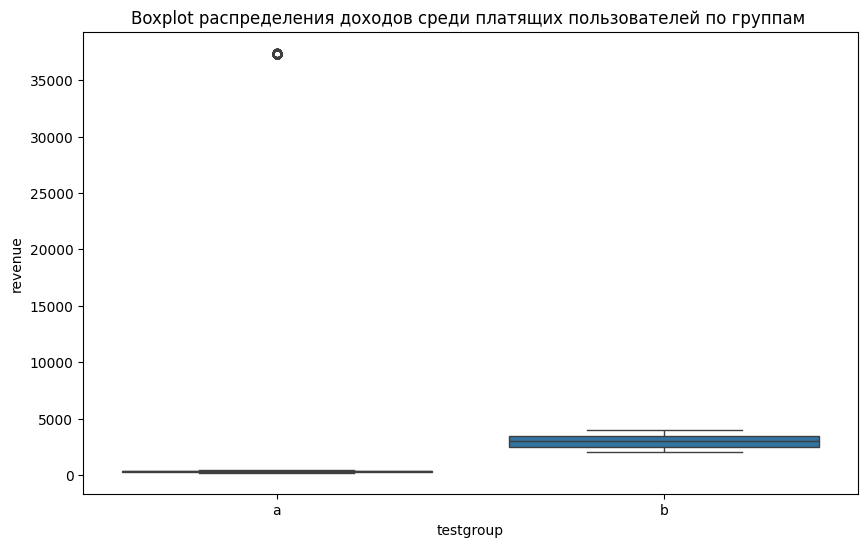

In [42]:
# Проведем анализ выбросов 
plt.figure(figsize=(10, 6))
sns.boxplot(x='testgroup', y='revenue', data=gen_data.query ('revenue > 0'))
plt.title('Boxplot распределения доходов среди платящих пользователей по группам ')
plt.show()

добавим еще одну визуализацию 

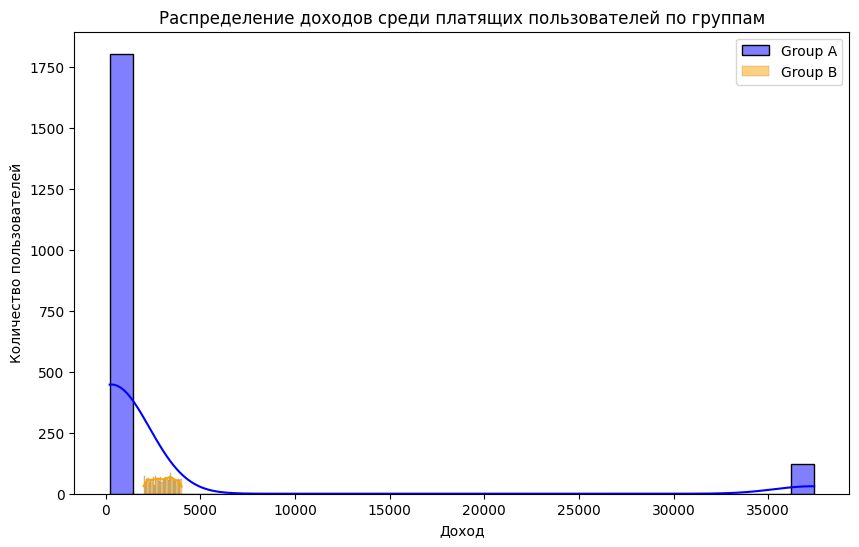

In [43]:

plt.figure(figsize=(10, 6))
sns.histplot(a_paying['revenue'], color='blue', label='Group A', kde=True, bins=30)
sns.histplot(b_paying['revenue'], color='orange', label='Group B', kde=True, bins=30)

plt.title('Распределение доходов среди платящих пользователей по группам')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend()

plt.show()

Если выбросы считаются аномальными и не отражают поведение основной массы пользователей, их можно исключить. Для этого можно использовать 99-й процентиль.

In [44]:
a_paying['revenue'].var(), b_paying['revenue'].var() # Можно увидеть значительное различие в дисперсиях

(81885120.63985227, 327893.33153656696)

In [45]:
# Подтверждаем существенную разницу тестом Левене
stat_levene, p_value_levene = levene(a_paying['revenue'], b_paying['revenue'])

print(f"Статистика Левена: {stat_levene}, p-value: {p_value_levene}")

Статистика Левена: 80.85567421779912, p-value: 3.779689868667878e-19


In [46]:
# Рассчитываем 95-й квантиль для каждой группы среди платящих пользователей
quantile_95_a = a_paying['revenue'].quantile(0.95)
quantile_95_b = b_paying['revenue'].quantile(0.95)

outliers_a_count = a_paying[a_paying['revenue'] > quantile_95_a].shape[0]
outliers_b_count = b_paying[b_paying['revenue'] > quantile_95_b].shape[0]
outliers_a_count, outliers_b_count

quantile_95_a.max(), quantile_95_b.max()



(37299.65, 3891.8)

Даже при использовании 95-го процентиля наблюдаются значительные различия между доходами в группах. 

В нашем случае среднее значение будет лучшей метрикой для анализа, так как оно учитывает общие доходы от всех пользователей, включая тех, кто генерирует высокий доход. 
t-тест полезен для сравнения ARPU и ARPPU с продуктовой точки зрения, так как помогает объективно оценить эффективность акций и выявить, какое предложение приносит больше дохода, что поможет принять решения для оптимизации монетизации продукта.
На первый взгляд может показаться, что проведение t-теста вряд ли будет корректным. Это связано с тем, что t-тест в своей базе предполагает нормальное распределение данных и относительно равные дисперсии в группах. Однако в данном случае мы имеем очень большие выборки, что позволяет нам пренебречь этими требованиями.

Может показаться, что есть смысл попробовать провести тест Манна-Уитни, потому что он не требует нормальности распределения и устойчив к выбросам. Однако данный тест плохо подходит для сравнения двух средних, потому что его основная цель — сравнивать распределения двух выборок, а не их средние значения. Этот тест сравнивает распределение рангов и проверяет, есть ли сдвиг между двумя выборками, но не ориентирован на точное сравнение средних значений. 

3) t-тесты

In [47]:
# Сравнение ARPPU по группам
t_stat, p_value = scipy.stats.ttest_ind(a_paying['revenue'], b_paying['revenue'])
t_stat, p_value

(-1.5917100176862005, 0.11153459157259497)

t- тест не показал значимой разницы между нашими группами (p > 0.05). 

In [48]:
# Сравнение ARPU по группам
t_stat, p_value = ttest_ind(gen_data.query('testgroup == "a"').revenue, gen_data.query('testgroup == "b"').revenue)  # массивы ARPU по группам
print(f"T-статистика: {t_stat}, p-значение: {p_value}")


T-статистика: -0.6242026493616787, p-значение: 0.532494858971837


t- тест не показал значимой разницы между группами (p > 0.05). 

4) Посчитаем дополнительные показатели, чтобы определить, какой набор предложений можно считать лучшим

In [49]:
# Рассчитываем ARPPU (Average Revenue Per Paying User) для каждой группы
arppu_a = a_paying['revenue'].mean()  
arppu_b = b_paying['revenue'].mean()  

print(f"ARPPU для группы A: {arppu_a}")
print(f"ARPPU для группы B: {arppu_b}")


ARPPU для группы A: 2663.9984439834025
ARPPU для группы B: 3003.6581717451522


In [50]:
# Рассчитываем ARPU (Average Revenue Per User) для каждой группы
arpu_a = gen_data[gen_data['testgroup'] == 'a']['revenue'].sum() / len(gen_data[gen_data['testgroup'] == 'a'])
arpu_b = gen_data[gen_data['testgroup'] == 'b']['revenue'].sum() / len(gen_data[gen_data['testgroup'] == 'b'])

print(f"ARPU для группы A: {arpu_a}")
print(f"ARPU для группы B: {arpu_b}")
print (arpu_b/arpu_a)

ARPU для группы A: 25.413719736965806
ARPU для группы B: 26.75128659327863
1.052631683600699


In [51]:
# проверка максимального значения в тестовой группе
gen_data.query ('testgroup =="b"')['revenue'].max() 

4000

In [52]:
# Доля дохода, генерируемая топ 5% платящих пользователей группы A


sorted_a_paying = a_paying['revenue'].sort_values(ascending=False) #Отсортируем пользователей группы A по доходу

top_5_percent_count = int(len(sorted_a_paying) * 0.05) # Найдем количество пользователей, составляющих топ 5%

top_5_percent_revenue = sorted_a_paying.head(top_5_percent_count).sum() #Извлекаем доходы топ 5% пользователей

total_revenue_a = sorted_a_paying.sum() # Подсчитаем общий доход всех платящих пользователей в группе A


top_5_percent_share = top_5_percent_revenue / total_revenue_a * 100 # Рассчитаем долю дохода, которую генерируют топ 5% платящих пользователей

print(f"Доля дохода, генерируемая топ 5% платящих пользователей группы A: {top_5_percent_share:.2f}%")


Доля дохода, генерируемая топ 5% платящих пользователей группы A: 69.76%


In [53]:
# Доля дохода, генерируемая топ 5% платящих пользователей группы B


sorted_b_paying = b_paying['revenue'].sort_values(ascending=False)

top_5_percent_count = int(len(sorted_b_paying) * 0.05) 

top_5_percent_revenue = sorted_b_paying.head(top_5_percent_count).sum()

total_revenue_b = sorted_b_paying.sum() 


top_5_percent_share = top_5_percent_revenue / total_revenue_b * 100 

print(f"Доля дохода, генерируемая топ 5% платящих пользователей группы B: {top_5_percent_share:.2f}%")

Доля дохода, генерируемая топ 5% платящих пользователей группы B: 6.56%


In [54]:
# Конверсия (доля платящих пользователей от общего числа) для каждой группы
conversion_a = len(a_paying) / len(gen_data[gen_data['testgroup'] == 'a']) 
conversion_b = len(b_paying) / len(gen_data[gen_data['testgroup'] == 'b']) 

print(f"Конверсия для группы A: {conversion_a * 100:.2f}%")
print(f"Конверсия для группы B: {conversion_b * 100:.2f}%")

Конверсия для группы A: 0.95%
Конверсия для группы B: 0.89%


ВЫВОДЫ

ПО РЕЗУЛЬТАТАМ A/B ТЕСТА: 
1) Конверсия платящих пользователей выше в группе A (0.95% против 0.89% в группе B), что подтверждается результатом теста хи-квадрат (
p-value < 0.05). Это указывает на то, что акционные предложения в группе A эффективнее стимулируют пользователей совершать покупки. 

2) Доход на платящего пользователя (ARPPU) в группе B выше (3003.66 против 2663.99 в группе A). Однако по результатам теста p-value= ~11%, что говорит об отстутствии статистически значимой разницы в ARPPU между предложениями.

3) Хотя ARPU в группе B также выше (26.75 против 25.41 в группе A), результаты t-тестов показали (p-value ~53%), что различие в среднем доходе на пользователя и среднем доходе на платящего пользователя также не является статистически значимыми.

По этим результатам можно сделать вывод, что набор предложений у тестовой группы (B) не является лучше набора контрольной группы. Даже наоборот, присутствует статистическая разница в стимуляции к совершению покупок (больше покупают пользователи именно из контрольной группы), в то время как нет значимых разничий в ARPPU и ARPU между группами. По результатам тестов, набор акционных предложений из контрольной группы оказался лучше.


ДОПОЛНИТЕЛЬНЫЕ НАБЛЮДЕНИЯ, НЕ ИМЕЮЩИЕ ОТНОШЕНИЯ К РЕЗУЛЬТАТАМ A/B ТЕСТА:

Cтоит отметить, что основная доля дохода в группе A (~70%) сосредоточена у топ 5% пользователей (по визуализациям видно, что это ни один и не два пользователя, а минимум десятки, что существенно уменьшает вероятность ошибки или редкого исключения, тем более в группе b таких покупателей просто нет, максимальное revenue там-  4000), что делает группу сильно зависимой от небольшого числа крупных покупателей.

Также группа B демонстрирует более равномерное распределение доходов: топ 5% платящих пользователей генерируют только 6.56% от общего дохода. Это свидетельствует о более предсказуемом и стабильном распределении доходов среди платящих пользователей.





3 ЗАДАНИЕ

Часть 1: С помощью каких метрик можно оценить результаты последнего прошедшего события?


1. ОБЩИЙ АНАЛИЗ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ
1.1 Активность пользователей:
   Retention: Оценка удержания игроков, которые участвовали в событии. Например, сравнение возвращаемости пользователей в игру до и после события.
   Average Session Duration: увеличилось ли среднее время, проведенное игроками в игре, в течение события. Возможно, игроки проводили больше времени в игре, чтобы завершить задания.
   Количество уровней, пройденных во время события: Сколько уровней в среднем прошли игроки во время события? 
   
1.2. Монетизация
    ARPU: Средний доход на пользователя в период события. Важно сравнить с обычным периодом.
    ARPPU: Средний доход на платящего игрока. Как изменились траты среди активных покупателей?
    Conversion Rate: Процент пользователей, которые совершили внутриигровые покупки во время события.
    Средний чек: Средний размер транзакции среди игроков, сделавших покупку во время события.
    Частота покупок: Как часто пользователи совершали покупки во время события? Сравнить с предыдущими периодами.

1.3. Прогресс игроков
Количество завершенных уровней: Процент пользователей, которые завершили все уровни события. Сравнить с теми, кто завершил только часть уровней.
Среднее количество попыток на уровень: Сколько попыток в среднем требовалось пользователям для завершения уровней? Высокое количество попыток может сигнализировать о сложности.
Показатель завершения события: Процент игроков, завершивших событие полностью. Какие группы пользователей (например, новички, средние игроки или олды) показали лучшие результаты?


2. СТАТИСТИЧЕСКИЙ ПОДХОД
Применение всех следующих тестов для сравнения результатов как внутри одного события, так и с предыдущими ежемесячными событиями.

2.1. A/B тестирование: Разделение пользователей на группы с разными условиями события (например, разные временные рамки, уровни сложности или награды) и сравнение их результатов. Важно использовать такие статистические тесты, как t-тест, z-тест, или тест Манна-Уитни для сравнения метрик в группах.

2.2. Анализ нормальности и дисперсий
Тесты на нормальность (Шапиро-Уилка, Колмогорова-Смирнова): Оценка распределений ключевых метрик, таких как доходы или количество завершенных уровней.
Анализ дисперсий (ANOVA, тест Левена): Сравнение дисперсий показателей, таких как прогресс в уровнях или количество покупок, между разными группами игроков.

2.3. Корреляционный анализ
Корреляция между метриками (Pearson, Spearman): Например, как количество пройденных уровней коррелирует с внутриигровыми покупками? Есть ли связь между временем, проведенным в игре, и завершением события?

2.4. Регрессионный анализ
Множественная регрессия: Построение модели для оценки факторов, которые влияют на завершение события или на доходы. Можно использовать переменные, такие как возраст аккаунта, активность до события, участие в предыдущих событиях, покупки и т. д.

2.5. Частотный анализ и анализ сегментации
Кластеры пользователей (кластеризация): Разделение пользователей на кластеры в зависимости от их активности, трат и прогресса в игре. Это позволит лучше понять поведение разных типов игроков во время события.
Анализ сегментов: Оценка результатов события для разных сегментов игроков — новички, регулярные игроки, крупные покупатели, "спящие" игроки.


3. МЕТРИКИ ИЗ ПРОДУКТОВОЙ АНАЛИТИКИ
3.1. Путь пользователя через уровни: Какие уровни были наиболее сложными или на каких этапах игроки чаще всего прерывали участие в событии?
Воронка выполнения события: Показатель того, сколько пользователей начало событие, сколько прошло половину и сколько завершило все уровни. Это поможет выявить узкие места в игровом процессе.

3.2. Качество и привлекательность наград: Проанализировать, как пользователи взаимодействовали с уникальными наградами — сколько пользователей завершили событие ради них и насколько часто они использовались после завершения события.
Анализ покупок в контексте событий: Были ли покупки внутриигровой валюты, предметов или бустеров непосредственно связаны с желанием пользователей ускорить завершение уровней и получение наград?

3.3. Сложность события
Анализ сложности уровней: Какие уровни были завершены быстрее всего, а на каких игроки проводили больше времени? Это поможет определить баланс сложности.
Обратная связь игроков: Использовать аналитику обратной связи от пользователей (возможно, через отзывы или внутриигровые опросы) для оценки сложности уровней и ценности наград.

3.4. Активность новичков
Retention новых игроков, пришедших в период события: Как событие повлияло на новых пользователей? Оценить их удержание и активность в первые дни после события.

3.5. Событие как инструмент возвращения игроков
Повторная активация спящих пользователей: События часто используются для возвращения старых игроков. Сколько "спящих" игроков вернулось в игру и насколько долго они оставались активными после окончания события.

3.6. Оценка удовлетворенности пользователей: Оценка того, насколько игроки довольны событием и будут ли они рекомендовать игру другим пользователям. Это можно измерить через опросы или обратную связь внутри игры.


Часть 2: Изменится ли набор метрик оценки результата? Если да, то как?

При изменении механики события, где игроки откатываются на несколько уровней назад при неудачной попытке, набор метрик для оценки результатов события действительно изменится. Это связано с тем, что такая механика может сильно повлиять на поведение игроков, их вовлеченность, монетизацию и эмоциональную реакцию.

Во-первых, важно будет отслеживать среднее количество попыток на уровень. Из-за откатов игрокам может понадобиться больше попыток для прохождения сложных этапов, и это будет критически важной метрикой, чтобы понять, насколько усложнилась игра. Также стоит добавить метрику количества уровней, с которых игроки откатывались назад- это даст представление о том, насколько часто игроки сталкивались с откатами и сколько уровней теряли после неудач.

Ещё одной важной метрикой станет количество завершенных уровней и процент завершивших событие игроков. Учитывая усложнение игры, можно ожидать, что больше пользователей не смогут завершить событие до конца, поэтому анализ прогресса игроков станет особенно важным. Нужно будет смотреть, на каких уровнях игроки чаще всего застревали и откатывались назад, чтобы оценить баланс сложности в игровом процессе.

В части монетизации стоит обратить внимание на изменения в покупках бустеров или внутриигровой валюты. Игроки, столкнувшиеся с откатами, могут чаще совершать покупки, чтобы ускорить прохождение уровней. Поэтому нужно отслеживать, как изменился объем и частота таких покупок во время события. Здесь также важным будет анализ, сколько покупок было совершено после откатов- это поможет понять, мотивирует ли новая механика пользователей тратить больше денег.

Кроме того, можно ожидать изменения в поведении пользователей относительно выхода из игры. Если механика откатов будет слишком фрустрирующей, игроки могут чаще покидать игру, не завершив уровень, и это нужно будет измерить с помощью метрики количества досрочных выходов из игры. Отсюда же следует необходимость замера оттока игроков после события: если усложнение механики вызовет сильную фрустрацию, можно ожидать рост оттока после окончания события, и это также стоит сравнить с предыдущими периодами.

Также нужно учитывать, что усложнение игры может повлиять на общую вовлеченность игроков. Можно замерять изменение среднего времени, проведенного в игре, а также построить кривые прогресса, чтобы увидеть, насколько быстро игроки продвигались через уровни события и как часто откатывались назад.

Новая механика также потребует анализа обратной связи от пользователей. Из-за усложнения событий нужно понять, насколько игроки довольны такой механикой, не вызывает ли она чрезмерную фрустрацию. Это можно сделать через опросы или сбор отзывов внутри игры. Важной метрикой здесь станет насколько игроки довольны событием и готовы рекомендовать игру другим.

Стоит провести A/B тестирование, чтобы сравнить результаты группы с механикой откатов и без неё. Это позволит оценить влияние новой механики на такие ключевые показатели, как доходы, количество попыток на уровень, процент завершенных событий и покупки. Сравнение этих групп с помощью статистических тестов (например, тест Манна-Уитни или t-тест) поможет выявить значимость различий и принять решение о дальнейших изменениях в механике.